<a href="https://colab.research.google.com/github/rbqpark/tinger/blob/main/TingerIntegration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#**1. Mount Google Drive and get authentication from Google SDK**#

This step includes mounting the Google Drive and receiving authentication via Google SDK to gain access to our database and custom libraries.

In [ ]:
from google.colab import drive, auth
from oauth2client.client import GoogleCredentials
import gspread

# mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# authenticate to gain access to read CSV files from Google Drive
auth.authenticate_user()
gc = gspread.authorize(GoogleCredentials.get_application_default())

------------------------------------------
#**2. Install and import all dependencies**#

In [ ]:
#@title
# Install libraries not local to Colab
!pip install tensorflow
!pip install tensorflow-gpu
!pip install import-ipynb
!pip install chinese-converter
!pip install anvil-uplink

     |████████████████████████████████| 394.3MB 44kB/s 
  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-cp37-none-any.whl size=2976 sha256=04b7a22401626a37f13e7bf9242734912a00d20f99f3331235eda85f76b5474d
  Stored in directory: /root/.cache/pip/wheels/b4/7b/e9/a3a6e496115dffdb4e3085d0ae39ffe8a814eacc44bbf494b5
Successfully built import-ipynb
     |████████████████████████████████| 194kB 17.1MB/s 
     |████████████████████████████████| 61kB 9.2MB/s 
     |████████████████████████████████| 61kB 9.7MB/s 
  Created wheel for ws4py: filename=ws4py-0.5.1-cp37-none-any.whl size=45216 sha256=09da51a410ebdef5a151cc582fc7e24009b1ddef3fcb1def2405f0899bad0085
  Stored in directory: /root/.cache/pip/wheels/a2/6e/4e/8b0ae12fb9b8a05715256952cf7609a8ab86285fab99b88c68
Successfully built ws4py


In [ ]:
#@title
# Must move current directory into Tinger's main code directory
%cd '/content/drive/MyDrive/Tinger/Code/'

/content/drive/.shortcut-targets-by-id/1MmUoTMTlJTAmm1As2rqatiDS3yAAsfgG/Tinger/Code


In [ ]:
#@title
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import chinese_converter
from PIL import Image
from timeit import default_timer

# import keras
from tensorflow import keras

# import custom SNN functions from UseSNN.ipynb in the same directory
import import_ipynb
import UseSNN

# import sklearn
from sklearn.neighbors import KNeighborsClassifier

# import difflib
from difflib import SequenceMatcher

importing Jupyter notebook from UseSNN.ipynb
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


------------------------------------------
#**3. Pre-process and store data in advance to save runtime**#

By making calculations and transforming data in advance to making recommendations in real-time, Tinger is able to cut down on runtime.

In [ ]:
path = '/content/drive/MyDrive/Tinger/Documentation/'

mandarin = pd.read_csv(path + 'Final Playlist Data (Mandarin).csv')
mandarin = mandarin.drop(columns=['Length of Song', 'Length in Seconds'])
mandarin['bpm'].replace('', np.nan, inplace=True)
mandarin = mandarin.dropna(subset = ["bpm"])
mandarin

,Song Title,Artist,Male0 / Female1/Other3,Publish Year,Solo0 / Group1,Main Chord Progression,Romance,Lyrics,Translated Lyrics,bpm,danceability
0,我很快乐,周兴哲,0,2020,0,"1,5,6,3,4,5,3,6",0.0,雷雨依舊 奔跑著 世界像你 模糊停格 總以為能 永遠愛著 時間 卻幫我們上了一課 路 無法倒...,Rain still run the world like you always think...,74.402031,1.065184
1,过,林俊杰，王嘉尔,0,2020,0,"1,7,4,1,6,3,2,5",0.0,回不去 的路口 oh oh 像過敏 紮了根 oh oh 我想起 某個人 oh oh 在我心中...,Go back through the intersection like oh oh oh...,128.099670,1.161731
3,很久以后,邓紫棋,1,2020,0,"1,6,4,5,1,6,4,5",0.0,也許是不甘心 也許是可惜 也許無法相信 突然身邊再也不是你 能給的都已經給你 能做的都用盡全...,Maybe not willing to believe maybe but maybe n...,145.184540,1.059654
4,莲,张艺兴,0,2020,0,"1,3,6,3,4,3,6,2",0.0,Look at me good You make an answer Look at me ...,Look at me good You make an answer Look at me ...,109.927071,1.125244
5,好想爱这个世界啊,华晨宇,0,2019,0,"4,5,6,4,5,6,4,5",0.0,抱着沙发 睡眼昏花 凌乱头发 却渴望像电影主角一样潇洒 屋檐角下 排着乌鸦 密密麻麻 被压抑...,Sofa holding sleepy eyes dim messy hair was lo...,162.003204,0.961398
...,...,...,...,...,...,...,...,...,...,...,...
248,水调歌头,郑云龙,0,2021,0,"6,5,4,5,3,5,4,5",0.0,明月几时有 把酒问青天 不知天上宫阙 今夕是何年 我欲乘风归去 又恐琼楼玉宇 高处不胜寒 起...,Comparative study of wine in the sky do not kn...,129.562775,1.073043
249,淒美地,郭頂,0,2016,0,"4,1,3,4,1,3,4,1",1.0,曾經我是不安河水 穿過森林誤入你心 沒計劃紮營 擱下了是非 一去不回 如今我是造夢的人...,Once I was disturbed by the river through the ...,125.038483,1.560385
250,你是如此难以忘记,李宇春,0,2014,0,"1,6,1,3,2,5,1,6",1.0,早已知道爱情是难舍难离早已知道爱一个人不该死心塌地早已不再相信所谓天长地久的结局所以我习惯了...,Already know that love is reluctant to leave h...,116.767136,0.881414
251,致姍姍來遲的你,阿肆,3,2016,0,"4,5,3,6,4,5,1,1",1.0,我不介意你慢動作 也不介意這次先擦肩而過 吃一人份的飯 刷一人份的碗 真的我並沒有覺得孤單 ...,I do not mind if you do not mind the slow moti...,120.003136,1.321027


In [ ]:
mandarin.loc[len(mandarin.index)] = ['WAP', 'Cardi B', 1, 2020, 0, '1,1,2,1,1,2,1,1', 0.0, 'sa', 'dasd', 132.8644257, 1.191560388]
mandarin.loc[len(mandarin.index)+1] = ['Rockstar', 'Post Malone', 0, 2017, 0, '6,5,6,5,6,5,6,5', 0.0, 'dasd', 'dasdas', 161.6918945, 1.118424296]
mandarin.loc[len(mandarin.index)+2] = ['Holy', 'Justin Bieber', 0, 2020, 0, '1,5,6,4,1,5,6,4', 0.0, 'sda', 'sad', 86.79120636, 1.164459944]

In [ ]:
english = pd.read_csv(path + 'Final Playlist Data (English).csv')
english = english.drop(columns=['Length of Song', 'Length in Seconds'])
english['bpm'].replace('', np.nan, inplace=True)
english = english.dropna(subset = ["bpm"])
english

,Song Title,Artist,Male0 / Female1/Other3,Publish Year,Solo0 / Group1,Main Chord Progression,Romance,Lyrics,bpm,danceability
1,Save Your Tears,The Weeknd,0,2020,0,"2,6,4,4,1,6,3,5",1,Ooh Yeah I saw you dancing in a crowded room Y...,117.723969,1.513067
2,Blinding Lights,The Weeknd,0,2020,0,"2,6,1,5,2,6,1,5",1,Yeah I've been tryin' to call I've been on my ...,85.510956,1.261864
3,Rain on me,"Lady Gaga, Ariana Grande",1,2020,0,"1,5,6,5,1,6,5,1",0,I didn't ask for a free ride I only asked you ...,123.091164,1.185066
4,Intentions,Justin Bieber,0,2020,0,"1,1,6,4,6,4,1,1",1,"Picture perfect, you don't need no filter Gorg...",147.990478,1.051466
5,Mood,24KGoldn,0,2020,0,"4,6,1,5,4,6,1,5",1,"Why you always in a mood? Fuckin 'round, actin...",90.814598,1.072854
...,...,...,...,...,...,...,...,...,...,...
194,Indigo,NIKI,1,2019,0,"4,1,6,5,4,1,6,5",1,"Oh-oh-oh-oh-oh Oh-oh-oh-mm-mm Yeah, yeah Yeah,...",144.773621,1.237753
195,bury a friend,Billie Eilish,1,2019,0,"1,1,1,1,1,4,5,1",0,What do you want from me? Why don't you run fr...,118.372833,1.066214
197,Fly Me To The Moon,Frank Sinatra,0,1954,0,"1,3,6,2,5,3,4,1",1,Fly me to the moon Let me play among the stars...,117.308304,0.975252
198,Bad Romance,Lady Gaga,1,2009,0,"1,2,5,1,2,6,1,2",1,Oh-oh-oh-oh-oh-oh-oh-oh-oh-oh-oh-oh! Caught in...,118.253670,1.294277


In [ ]:
# Calculate chord differences for English dataset
chord_progressions = english['Main Chord Progression']
chord_list = chord_progressions.values.tolist()
empty_list = []
for value in chord_list:
    temp = list(map(int, value.split(',')))
    empty_list.append([j-i for i, j in zip(temp[:-1], temp[1:])])
english['Chord Difference'] = empty_list
    
# Calculate chord differences for Mandarin dataset
chord_progressions1 = mandarin['Main Chord Progression']
chord_list_mandarin = chord_progressions1.values.tolist()
empty_list1 = []
for value in chord_list_mandarin:
    temp1 = list(map(int, value.split(',')))
    empty_list1.append([j-i for i, j in zip(temp1[:-1], temp1[1:])])
mandarin['Chord Difference'] = empty_list1

------------------------------------------
#**4. Define Tinger's main recommendation functions**#

In [ ]:
def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

In [ ]:
def tinger_no_snn(song_title, eng):
    """
    
    Inputs: 
        song_title : string, the title of song the user likes
        
        eng : boolean, True if input song is in English; False if input song is in Mandarin
        
    Outputs:
        song_recs : 5 song recommendations in the other language
    
    """

    # Identify all the paths needed -- paths may be different for different users
    model_path = '/content/drive/MyDrive/Tinger/Code/'

    mandarin_mel_path = '/content/drive/MyDrive/Tinger/Code/WAVtoShortMelSpectrogram-Output/Mel_Mandarin'
    english_mel_path = '/content/drive/MyDrive/Tinger/Code/WAVtoShortMelSpectrogram-Output/Mel_English'

    mandarin_csv_path = '/content/drive/MyDrive/Tinger/Documentation/Final Playlist Data (Mandarin).csv'
    english_csv_path = '/content/drive/MyDrive/Tinger/Documentation/Final Playlist Data (English).csv'
        
    if eng:
        #get romance label of input song
        r = english[english['Song Title']==song_title]['Romance']
        
        #add metadata distances
        X = mandarin.iloc[:, 2:5].values
        y = mandarin.iloc[:, 0].values
        x = english[english['Song Title']==song_title].iloc[:, 2:5].values
        classifier = KNeighborsClassifier(n_neighbors=len(mandarin))
        classifier.fit(X, y)
        distances, indices = classifier.kneighbors(x, n_neighbors=len(mandarin))
        dist = pd.DataFrame(distances[0], indices[0]).rename(columns={0: "meta_dist"})
        final = mandarin.merge(dist, how='inner', left_index=True, right_index=True)
        
        #add bpm distances
        man_X = mandarin.iloc[:, 9:11].values
        man_y = mandarin.iloc[:, 0].values
        x1 = english[english['Song Title']==song_title].iloc[:, 8:10].values
        bpm_classifier = KNeighborsClassifier(n_neighbors=len(mandarin))
        bpm_classifier.fit(man_X, man_y)
        distances1, indices1 = bpm_classifier.kneighbors(x1, n_neighbors=len(mandarin))
        dist1 = pd.DataFrame(distances1[0], indices1[0]).rename(columns={0: "bpm_dist"})
        final = final.merge(dist1, how='inner', left_index=True, right_index=True)
        
        #add chord progression similarity scores
        diff = english.loc[english['Song Title'] == song_title]['Chord Difference'].values[0]
        final['chord_sim'] = mandarin['Chord Difference'].map(lambda y: similar(y, diff))
        
        # #add snn similarity scores
        # output = UseSNN.similarities_matrix(model_path, mandarin_mel_path, english_mel_path, english_csv_path, song_title, 1)
        # similarities_matrix = output[0]
        # comparison_titles = output[3]
        # final_dict = UseSNN.similarities_dict(similarities_matrix, comparison_titles)

    else:
        #get romance label of input song
        r = mandarin[mandarin['Song Title']==song_title]['Romance']

        #add metadata distances
        X = english.iloc[:, 2:5].values
        y = english.iloc[:, 0].values
        x = mandarin[mandarin['Song Title']==song_title].iloc[:, 2:5].values
        meta_classifier = KNeighborsClassifier(n_neighbors=len(english))
        meta_classifier.fit(X, y)
        distances, indices = meta_classifier.kneighbors(x, n_neighbors=len(english))
        dist = pd.DataFrame(distances[0], indices[0]).rename(columns={0: "meta_dist"})
        final = english.merge(dist, how='inner', left_index=True, right_index=True)
        
        #add bpm distances
        eng_X = english.iloc[:, 8:10].values
        eng_y = english.iloc[:, 0].values
        x1 = mandarin[mandarin['Song Title']==song_title].iloc[:, 9:11].values
        bpm_classifier = KNeighborsClassifier(n_neighbors=len(english))
        bpm_classifier.fit(eng_X, eng_y)
        distances1, indices1 = bpm_classifier.kneighbors(x1, n_neighbors=len(english))
        dist1 = pd.DataFrame(distances1[0], indices1[0]).rename(columns={0: "bpm_dist"})
        final = final.merge(dist1, how='inner', left_index=True, right_index=True)
        
        #add chord progression similarity scores
        diff = mandarin.loc[mandarin['Song Title'] == song_title]['Chord Difference'].values[0]
        final['chord_sim'] = english['Chord Difference'].map(lambda y: similar(y, diff))

        #add snn similarity scores
        # path = '/content/drive/My Drive/Tinger/Code/WAVtoShortMelSpectrogram-Output/Mel_Mandarin/'
    
    # Compute final similarity score
    final['score'] = -.005*final['meta_dist']-.03*final['bpm_dist']+.8*final['chord_sim']
#    final['score'] = -.005*final['meta_dist']-.01*final['bpm_dist']+.5*final['chord_sim']
#     final['score'] = -.1*final['meta_dist']-.1*final['bpm_dist']+.5*final['snn_sim']+.5*final['chord_sim']
    
    # Filter out songs with different romance label
    final = final[final['Romance']==r.iloc[0]].sort_values('score', ascending=False)
    
    # Select top 5 most similar songs
    song_recs = final['Song Title'].iloc[0:5]

    return song_recs

In [ ]:
def tinger(song_title, eng):
    """
    
    Inputs: 
        song_title : string, the title of song the user likes
        
        english : boolean, True if input song is in English; False if input song is in Mandarin
        
    Outputs:
        song_recs : 5 song recommendations in the other language
    
    """

    # Identify all the paths needed -- paths may be different for different users
    model_path = '/content/drive/MyDrive/Tinger/Code/'

    mandarin_mel_path = '/content/drive/MyDrive/Tinger/Code/WAVtoShortMelSpectrogram-Output/Mel_Mandarin'
    english_mel_path = '/content/drive/MyDrive/Tinger/Code/WAVtoShortMelSpectrogram-Output/Mel_English'

    mandarin_csv_path = '/content/drive/MyDrive/Tinger/Documentation/Final Playlist Data (Mandarin).csv'
    english_csv_path = '/content/drive/MyDrive/Tinger/Documentation/Final Playlist Data (English).csv'
        
    if eng:
        #get romance label of input song
        r = english[english['Song Title']==song_title]['Romance']
        
        #add metadata distances
        X = mandarin.iloc[:, 2:5].values
        y = mandarin.iloc[:, 0].values
        x = english[english['Song Title']==song_title].iloc[:, 2:5].values
        classifier = KNeighborsClassifier(n_neighbors=len(mandarin))
        classifier.fit(X, y)
        distances, indices = classifier.kneighbors(x, n_neighbors=len(mandarin))
        dist = pd.DataFrame(distances[0], indices[0]).rename(columns={0: "meta_dist"})
        final = mandarin.merge(dist, how='inner', left_index=True, right_index=True)
        
        #add bpm distances
        man_X = mandarin.iloc[:, 9:11].values
        man_y = mandarin.iloc[:, 0].values
        x1 = english[english['Song Title']==song_title].iloc[:, 8:10].values
        bpm_classifier = KNeighborsClassifier(n_neighbors=len(mandarin))
        bpm_classifier.fit(man_X, man_y)
        distances1, indices1 = bpm_classifier.kneighbors(x1, n_neighbors=len(mandarin))
        dist1 = pd.DataFrame(distances1[0], indices1[0]).rename(columns={0: "bpm_dist"})
        final = final.merge(dist1, how='inner', left_index=True, right_index=True)
        
        #add chord progression similarity scores
        diff = english.loc[english['Song Title'] == song_title]['Chord Difference'].values[0]
        final['chord_sim'] = mandarin['Chord Difference'].map(lambda y: similar(y, diff))
        
        #add snn similarity scores
        output = UseSNN.similarities_matrix(model_path, english_mel_path, mandarin_mel_path, mandarin_csv_path, song_title, 0)
        similarities_matrix = output[0]
        comparison_titles = output[3]
        final_dict = UseSNN.similarities_dict(similarities_matrix, comparison_titles)
        d = {'Song Title': final_dict.keys(), 'snn_sim': final_dict.values()}
        snn_df = pd.DataFrame(data=d)
        final = final.merge(snn_df, how='inner', on='Song Title')
        

    else:
        #get romance label of input song
        r = mandarin[mandarin['Song Title']==song_title]['Romance']

        #add metadata distances
        X = english.iloc[:, 2:5].values
        y = english.iloc[:, 0].values
        x = mandarin[mandarin['Song Title']==song_title].iloc[:, 2:5].values
        meta_classifier = KNeighborsClassifier(n_neighbors=len(english))
        meta_classifier.fit(X, y)
        distances, indices = meta_classifier.kneighbors(x, n_neighbors=len(english))
        dist = pd.DataFrame(distances[0], indices[0]).rename(columns={0: "meta_dist"})
        final = english.merge(dist, how='inner', left_index=True, right_index=True)
        
        #add bpm distances
        eng_X = english.iloc[:, 8:10].values
        eng_y = english.iloc[:, 0].values
        x1 = mandarin[mandarin['Song Title']==song_title].iloc[:, 9:11].values
        bpm_classifier = KNeighborsClassifier(n_neighbors=len(english))
        bpm_classifier.fit(eng_X, eng_y)
        distances1, indices1 = bpm_classifier.kneighbors(x1, n_neighbors=len(english))
        dist1 = pd.DataFrame(distances1[0], indices1[0]).rename(columns={0: "bpm_dist"})
        final = final.merge(dist1, how='inner', left_index=True, right_index=True)
        
        #add chord progression similarity scores
        diff = mandarin.loc[mandarin['Song Title'] == song_title]['Chord Difference'].values[0]
        final['chord_sim'] = english['Chord Difference'].map(lambda y: similar(y, diff))

        #add snn similarity scores
        output = UseSNN.similarities_matrix(model_path, mandarin_mel_path, english_mel_path, english_csv_path, song_title, 0)
        similarities_matrix = output[0]
        comparison_titles = output[3]
        final_dict = UseSNN.similarities_dict(similarities_matrix, comparison_titles)
        d = {'Song Title': final_dict.keys(), 'snn_sim': final_dict.values()}
        snn_df = pd.DataFrame(data=d)
        final = final.merge(snn_df, how='inner', on='Song Title')
    
    # Compute final similarity score
    final['score'] = -.005*final['meta_dist']-.01*final['bpm_dist']+.8*final['chord_sim']+.2*final['snn_sim']
    
    # Filter out songs with different romance label
    final = final[final['Romance']==r.iloc[0]].sort_values('score', ascending=False)
    
    # Select top 5 most similar songs
    song_recs = final['Song Title'].iloc[0:5]

    return song_recs

------------------------------------------
#**5. Initialize Tinger's full stack**#

Tinger's models requires roughly 10x more time to run in its initial trial immediately after initialization. The following code block runs an initial test trial to decrease runtime for future trials: 13s on average per recommendation.

In [ ]:
print(tinger_no_snn('A Thousand Years', eng=True))
print(tinger('A Thousand Years', eng=True))

199      不将就
31      好久不见
23     恋爱ing
110       男孩
171      不将就
Name: Song Title, dtype: object
53      男孩
17    你的背包
95    目不转睛
51      兜圈
20    小步舞曲
Name: Song Title, dtype: object


-------------------------------
#**[Optional] Steps to implement the Tinger siamese neural network**#

In [ ]:
# Step 1: Identify all the paths needed -- paths may be different for different users
model_path = '/content/drive/MyDrive/Tinger/Code/'

mandarin_mel_path = '/content/drive/MyDrive/Tinger/Code/WAVtoShortMelSpectrogram-Output/Mel_Mandarin'
english_mel_path = '/content/drive/MyDrive/Tinger/Code/WAVtoShortMelSpectrogram-Output/Mel_English'

mandarin_csv_path = '/content/drive/MyDrive/Tinger/Documentation/Final Playlist Data (Mandarin).csv'
english_csv_path = '/content/drive/MyDrive/Tinger/Documentation/Final Playlist Data (English).csv'

**Note before advancing:**
1. Make sure that all necessary dependencies are installed and imported. Please run the first 5 code blocks, more than once if necessary, to ensure proper installation.

2. Click on the RAM/Disk info above on the top right of this notebook. Ensure that the notebook is running on a **Python 3 Google Compute Engine backend (GPU)**. If not, click **Change Runtime Type** on the bottom of the Resources tab to change the backend to a GPU, then re-run the notebook.

3. Prior test trials have shown that the SNN takes roughly 10x the runtime to compute similarity matrices on its first run. Before showcasing, try to run the model at least once in advance.

In [ ]:
# Step 2: Select a target song to run through Tinger's model stack
# Also identify the direction in which Tinger is recommending songs:
# Mandarin >> English:  direction = 0
# English  >> Mandarin: direction = 1

target = '好喜歡你'
direction = 0

# The function similarities_matrix() outputs a list of length 5 as follows:
# [results_matrix, target_title, target_data, comparison_title, comparison_data]
# In order to create the desired dictionary, only results_matrix and comparison_title are needed.
# All objects are provided regardless for the sake of completeness

# Arguments:
# similarities_matrix(snn_path, mandarin_mel_path, english_mel_path, csv_path, target_title, direction)

start_time = default_timer()
output = UseSNN.similarities_matrix(model_path, mandarin_mel_path, english_mel_path, english_csv_path, target, direction)
end_time = default_timer()
print('Calculating the similarities matrix takes {0} seconds to run.'.format(end_time-start_time))

Calculating the similarities matrix takes 22.17813901799991 seconds to run.


In [ ]:
similarities_matrix = output[0]
comparison_titles = output[3]

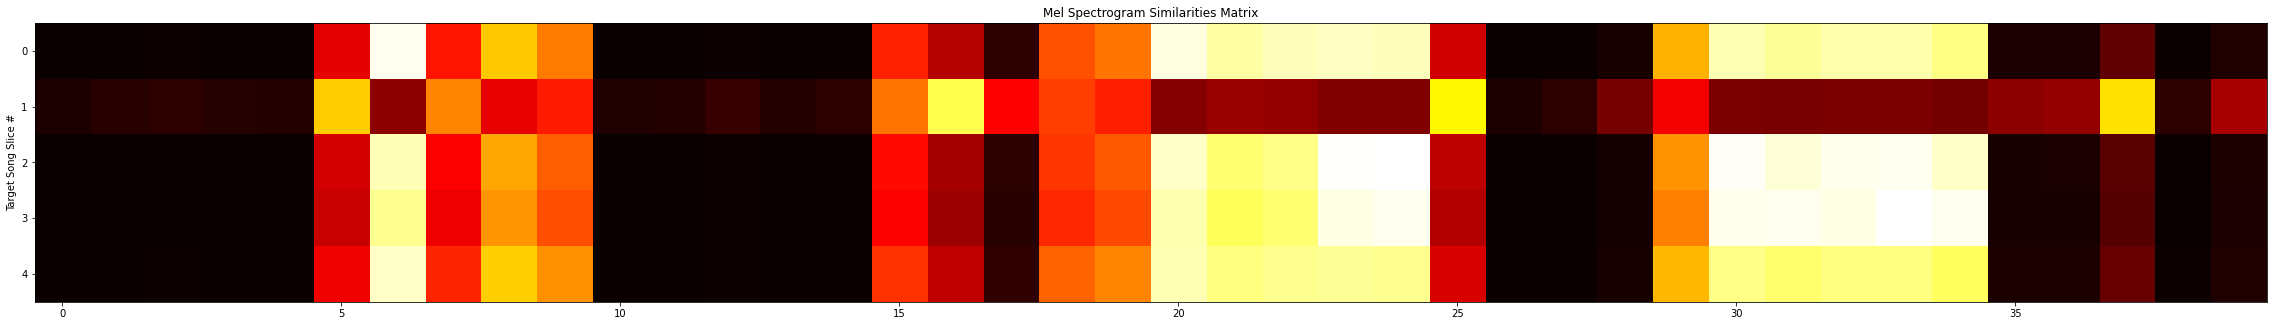

In [ ]:
# Step 3: Create a heatmap using the generate_heatmap() function for a graphical visual
# Use the similarities matrix from Step 2 as the input.
# Change the n_row and n_col arguments to create extracts of the matrix.
# Default values: n_row = 5 (highly recommended), n_col = 80
# Identify a filepath to save the heatmap

# Arguments:
# generate_heatmap(mat, n_row=5, n_col=40, save_path=None)

UseSNN.generate_heatmap(similarities_matrix)

In [ ]:
# Step 4: Retrieve the similarities matrix and comparison titles from the output in Step 2.
# Use them as inputs into the similarities_dict() function that outputs our final dictionary.
# This dictionary will be used as an input into the complete Tinger stack

start_time = default_timer()
final_dict = UseSNN.similarities_dict(similarities_matrix, comparison_titles)
end_time = default_timer()
print('Compiling the similarities dictionary takes {0} seconds to run.'.format(end_time-start_time))
print('Can\'t Lie has a similarty constant of {0} with the target song, {1}'.format(final_dict["Can't Lie"], target))

Compiling the similarities dictionary takes 0.0030612240000209567 seconds to run.
Can't Lie has a similarty constant of 0.004525488981744275 with the target song, 好喜歡你


-------------------------------
#**[Optional] Sample Outputs for Tinger's stack without and without the Siamese Neural Network**#

In [ ]:
# Test run of Tinger without siamese neural network
print(tinger_no_snn('A Thousand Years', eng=True))
print('\n')
print(tinger_no_snn('不将就', eng=False))

199      不将就
31      好久不见
23     恋爱ing
110       男孩
171      不将就
Name: Song Title, dtype: object


96                Stay
140            Secrets
108              34+35
72      What Lovers Do
1      Save Your Tears
Name: Song Title, dtype: object


In [ ]:
print(tinger('Perfect', eng=True))
print('\n')
print(tinger('雪花落下', eng=False))
print('\n')
print(tinger('暖暖', eng=False))
print('\n')
print(tinger('意外', eng=False))
print('\n')
print(tinger('你，好不好', eng=False))
print('\n')
print(tinger('男孩', eng=False))

70     雪花落下
99       暖暖
68       意外
44    你，好不好
53       男孩
Name: Song Title, dtype: object


124               Without Me
37                Photograph
33             Wrecking Ball
43     Make You Feel My Love
100               Hot N Cold
Name: Song Title, dtype: object


110       Beautiful In White
68     We Don't Talk Anymore
94                 Bad Blood
70             One Call Away
40          Someone Like You
Name: Song Title, dtype: object


91                     ME!
88               Positions
103     You Are The Reason
46                    Baby
64     Talking to the Moon
Name: Song Title, dtype: object


90           Love Story
51    She Will Be Loved
94            Bad Blood
47        Jar of Hearts
76                 Stay
Name: Song Title, dtype: object


124               Without Me
43     Make You Feel My Love
88                 Positions
13               Levitating 
18                 The Steps
Name: Song Title, dtype: object


In [ ]:
# 'Fake Mandarin' Sanity Test
print(tinger('WAP', eng=False))
print('\n')
print(tinger('Holy', eng=False))
print('\n')
print(tinger('Rockstar', eng=False))

5                         WAP
118         Unpack Your Heart
121                   Perfume
26                Uptown Funk
117    People Help The People
Name: Song Title, dtype: object


7                Holy
112    If I Die Young
73         Poker Face
17       Midnight Sky
48              Human
Name: Song Title, dtype: object


5                    WAP
2             Rain on me
6               Rockstar
98              Firework
34    Castle on the Hill
Name: Song Title, dtype: object


In [ ]:
# 'Fake Mandarin' Sanity Test 2
print(tinger_no_snn('WAP', eng=False))
print('\n')
print(tinger_no_snn('Holy', eng=False))
print('\n')
print(tinger_no_snn('Rockstar', eng=False))

146              Perfume
35           Uptown Funk
134        Big Girls Cry
114         Shake it Off
143    Unpack Your Heart
Name: Song Title, dtype: object


7            Rockstar
137    If I Die Young
73               Maps
80          24K Magic
30      See You Again
Name: Song Title, dtype: object


6                WAP
3         Rain on me
106    Thank U, Next
120         Firework
119             Roar
Name: Song Title, dtype: object


-------------------------------
#**6. Export to Web App using Anvil**#
**This cell must be running in order for our web app to stay alive.**

Must run all the cells above (except the 'Steps to Implement Tinger's SNN stack') to ensure dashboard works properly.

Most importantly, make sure all the dependencies are installed and imported correctly.

In [ ]:
import anvil.server

anvil.server.connect('AEDGXEE47FPVOY7EIKVZQWP4-A4FM7JK7KIDQP2JF')

@anvil.server.callable
def make_recommendation(song_title, eng):
  recs = tinger(song_title, eng)
  recs = recs.values

  return recs  

anvil.server.wait_forever()

KeyboardInterrupt: ignored